# Intel Image Classification with VGG16 - Transfer Learning and Fine-Tuning
A simple VGG16 transfer learning method with fine turning with above 96% accuracy and 93% validation accuracy

# Installing Required Libraries:
This code section installs the necessary libraries, including upgrading TensorFlow I/O to the latest version.


In [1]:
!pip install --upgrade tensorflow-io


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0
  Attempting uninstall: tensorflow-io
    Found existing installation: tensorflow-io 0.31.0
    Uninstalling tensorflow-io-0.31.0:
      Successfully uninstalled tensorflow-io-0.31.0


# Importing importent Libraries 
Here, we import the required libraries and modules for the model.

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import  Dense, Flatten, MaxPooling2D 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from datetime import datetime
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle           

import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import numpy as np
import shutil
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Defining Class Names and Variables:
We define the class names for image categories and other variables needed for the model. The dataset path is also set.

In [3]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
path = '/kaggle/input/intel-image-classification/'

classes_count = len(class_names)

IMAGE_SIZE = (150, 150)
Seed = 786

# **Downloading Dataset and splitting into Train and Test Sets**
Loading Data:
The load_data() function is defined to load the images and labels from the dataset. It reads the images, resizes them to a common size (150x150), and preprocesses them. The images are then split into training and testing sets.

In [4]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    path = '/kaggle/input/intel-image-classification/'
    datasets = [path +'seg_train/seg_train', path + 'seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [5]:
(train_images, train_labels), (test_images, test_labels) = load_data()
train_images, train_labels = shuffle(train_images, train_labels, random_state=786)


Loading /kaggle/input/intel-image-classification/seg_train/seg_train


100%|██████████| 2404/2404 [00:16<00:00, 146.89it/s]


Loading /kaggle/input/intel-image-classification/seg_test/seg_test


100%|██████████| 553/553 [00:03<00:00, 181.00it/s]


# Data Visualization
> This section visualizes sample images from each category in a 6x6 grid using Matplotlib.


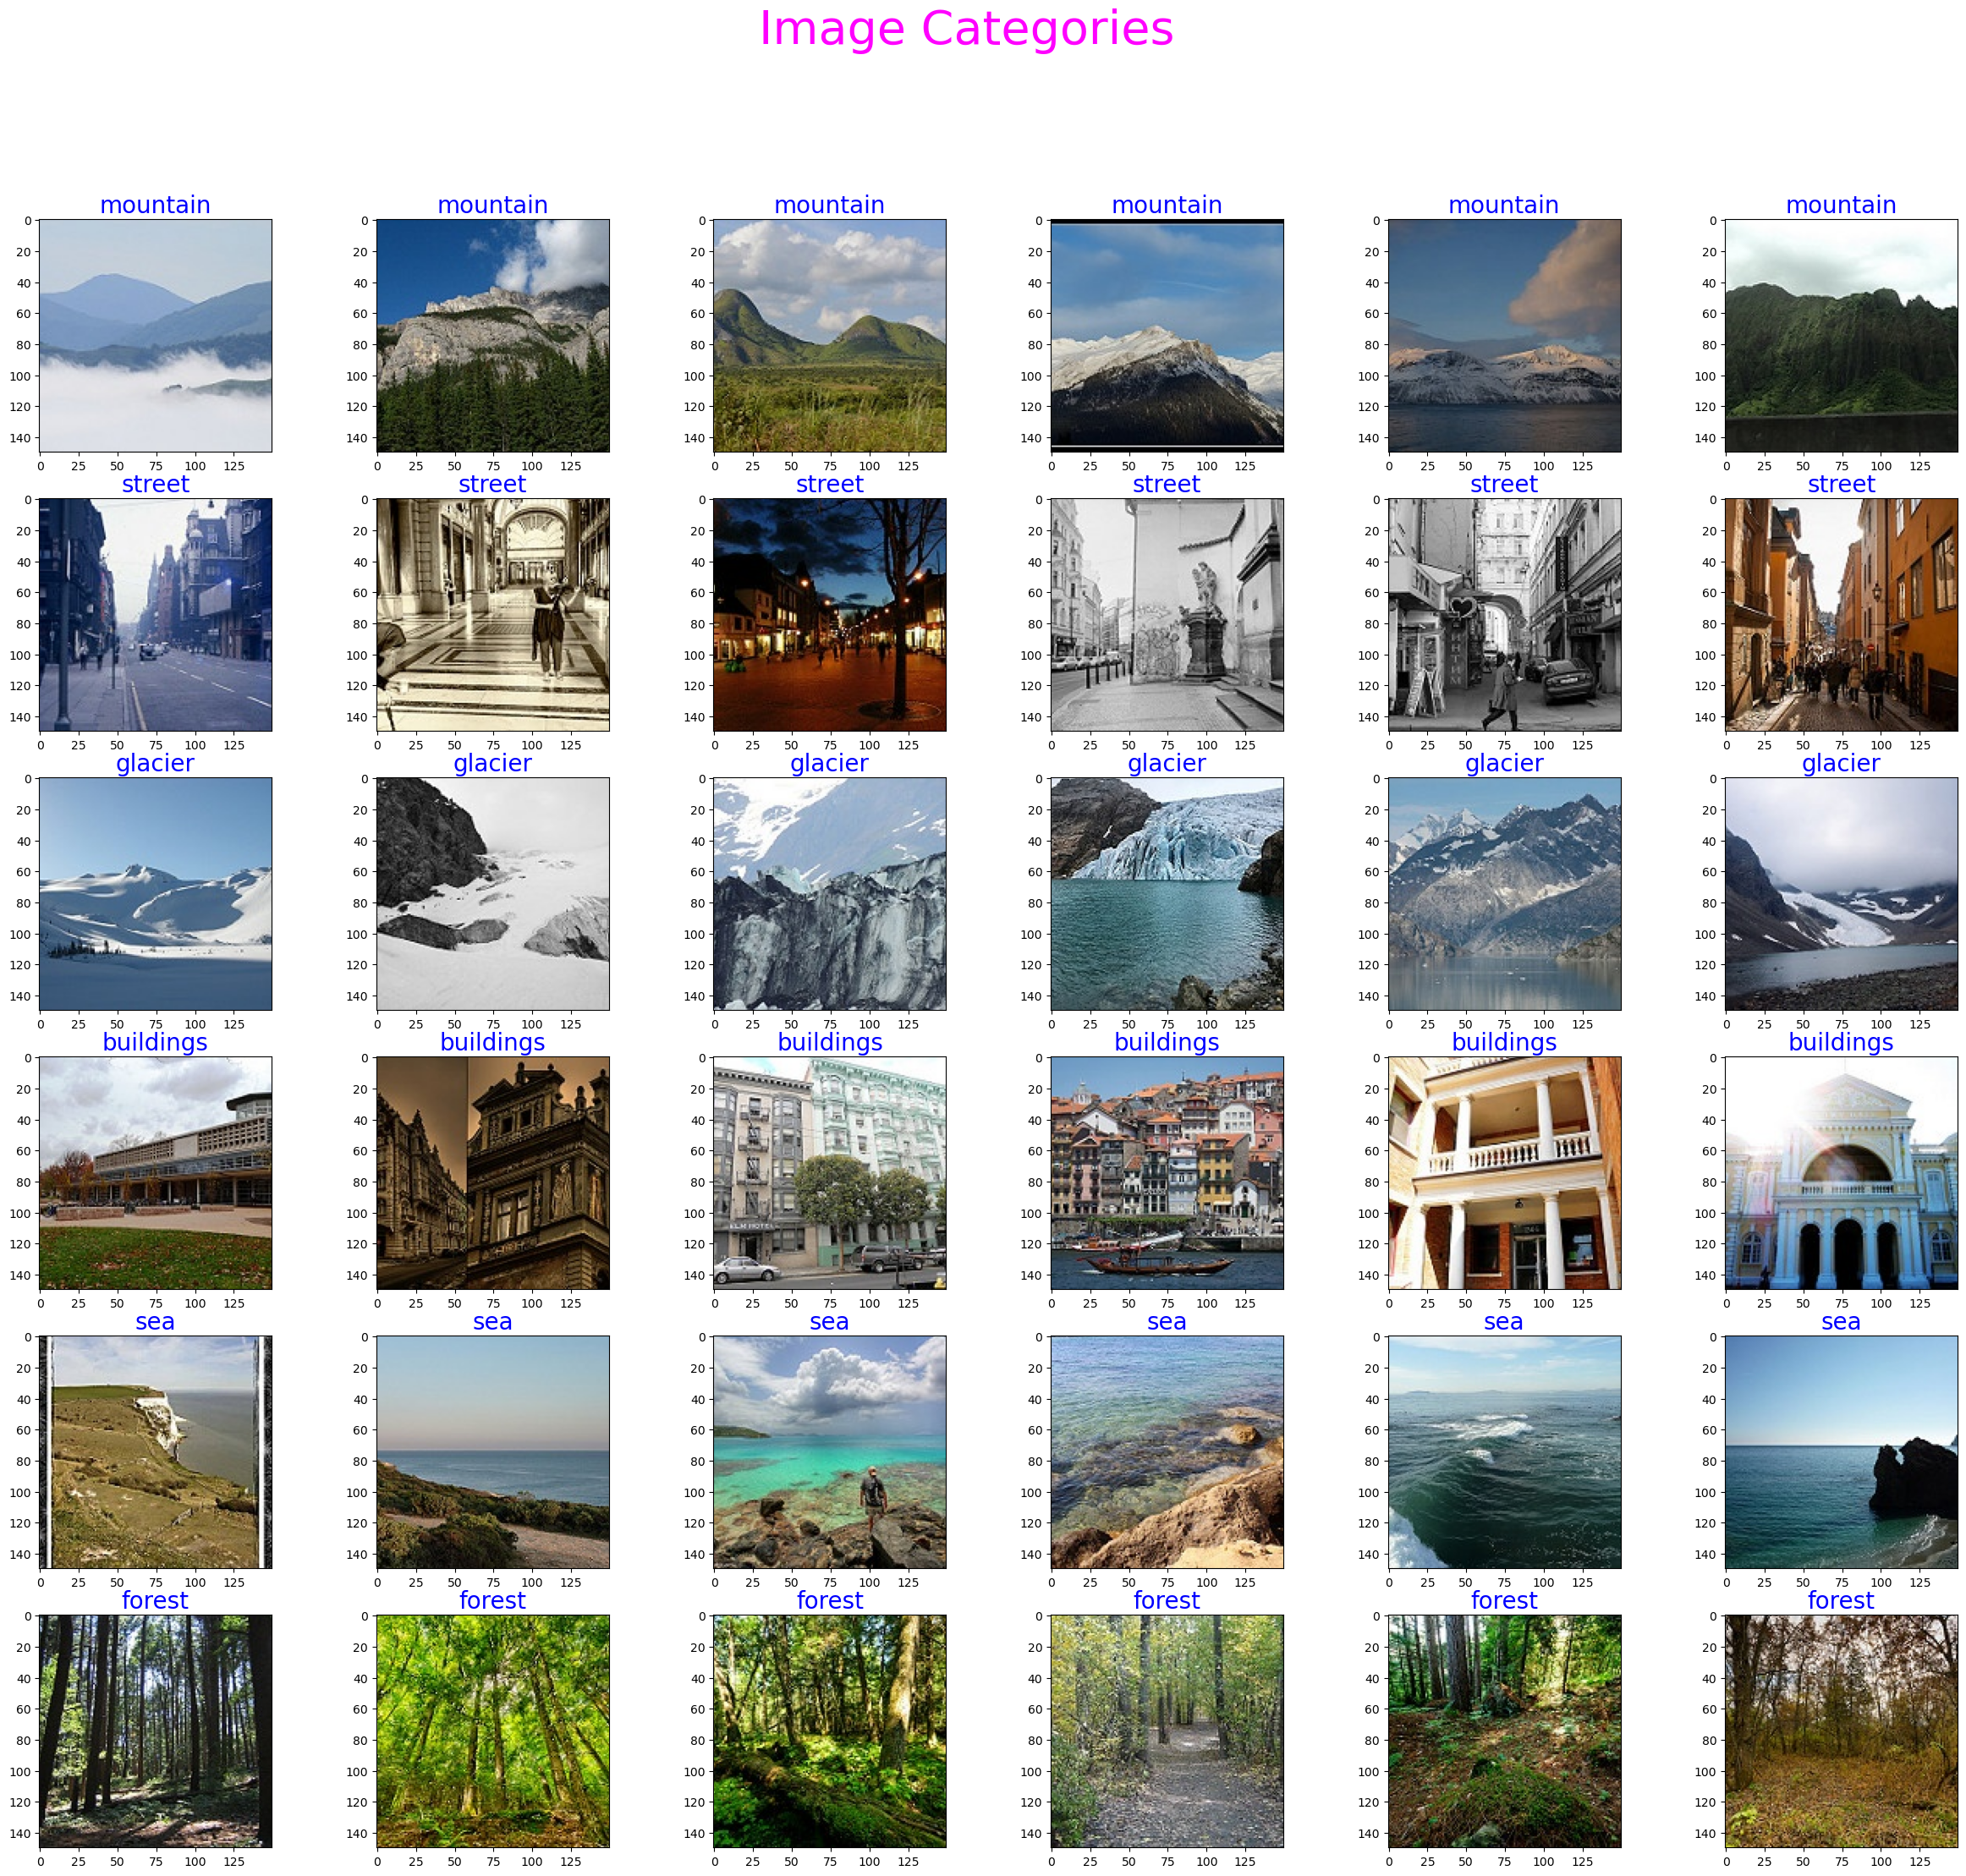

In [6]:
fig, ax = plt.subplots(6,6, figsize=(30,25))
fig.suptitle('Image Categories',color='magenta',fontsize=40)
for i in range(6):
    for j in range(6):
        im_src = path +'seg_train/seg_train/' + class_names[i] + '/'
        FileNames = os.listdir(im_src)
        im_src = str(im_src + FileNames[j])       
        imag = img.imread(im_src)
        ax[i, j].imshow(imag)
        ax[i, j].set_title(class_names[i],fontsize=20,color='blue')

# Data Augmentation:
Data augmentation is performed to increase the diversity of the training dataset. It applies various transformations to the images, such as rotation, shifting, shearing, zooming, horizontal flipping, and filling the empty space after augmentation.

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# test Data Augmentation 
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    )

train_datagen.fit(train_images)
test_datagen.fit(test_images)

# Generating Train and Test Sets:
Data generators are created for both the training and testing sets. The data generators will apply data augmentation and preprocess the images on-the-fly while training the model.

In [8]:
train_set = train_datagen.flow(train_images, 
                               train_labels,
                               batch_size = 64,
                                    )
test_set = test_datagen.flow(test_images,
                             test_labels,
                              batch_size = 64,
                              
                            )

# Setting up VGG16 Model:
The VGG16 model is downloaded with pre-trained weights from 'imagenet'. The model is set to use the input shape (150x150x3), which corresponds to the image size and the number of color channels.

In [9]:
IMAGE_SIZE = [150, 150, 3]
base_model = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


## Freezing VGG16 Parameters:
The VGG16 base model's layers are frozen, so they won't be updated during training. 

In [10]:
base_model.input
base_model.trainable = False


# Building the Final Model:
The VGG16 base model's output is connected to a GlobalAveragePooling2D layer to reduce spatial dimensions and then to a Dense layer with 6 units and softmax activation, corresponding to the 6 image categories.

In [11]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(6, activation = 'softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


# Setting Callbacks and Compiling the Model:
Callbacks like EarlyStopping and Learning Rate Scheduler are set up to monitor the training process and make adjustments accordingly. The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss

In [12]:
# Create early stopping callback based on training loss
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='loss', restore_best_weights=True)

# Create learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, monitor='loss', verbose=1, min_lr = 0.000001)


# Training the Model with Transfer Learning:
The model is trained using the data generators and the defined callbacks. The training process also includes early stopping, which halts training if the loss does not improve after a certain number of epochs.

In [13]:
adam = optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Start Training and Collecting best points 

In [14]:
checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)
callbacks = [checkpoint]
start = datetime.now()

model_history=model.fit(
                      train_set,
                      validation_data=test_set,
                      epochs=30,
                      validation_steps=32,
                      callbacks= [early_stopping, lr_scheduler, callbacks],
                      verbose=1)
        


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/30
220/220 [==============================] - ETA: 0s - loss: 7.1038 - accuracy: 0.5358
Epoch 1: val_loss improved from inf to 3.27111, saving model to mymodel.h5
220/220 [==============================] - 90s 371ms/step - loss: 7.1038 - accuracy: 0.5358 - val_loss: 3.2711 - val_accuracy: 0.7139 - lr: 0.0010
Epoch 2/30
220/220 [==============================] - ETA: 0s - loss: 3.1552 - accuracy: 0.6986
Epoch 2: val_loss improved from 3.27111 to 2.20062, saving model to mymodel.h5
220/220 [==============================] - 82s 371ms/step - loss: 3.1552 - accuracy: 0.6986 - val_loss: 2.2006 - val_accuracy: 0.7759 - lr: 0.0010
Epoch 3/30
220/220 [==============================] - ETA: 0s - loss: 2.3821 - accuracy: 0.7300
Epoch 3: val_loss improved from 2.20062 to 1.62018, saving model to mymodel.h5
220/220 [==============================] - 83s 376ms/step - loss: 2.3821 - accuracy: 0.7300 - val_loss: 1.6202 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 4/30
220/220 [==================

## Plotting Accuracy and Loss:
The accuracy and loss curves are plotted to visualize the model's performance before fine-tuning

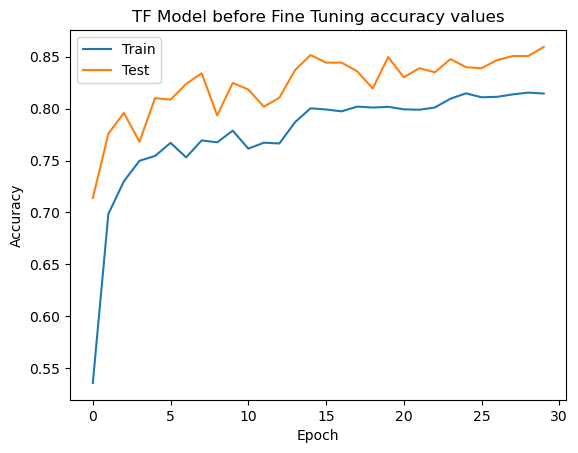

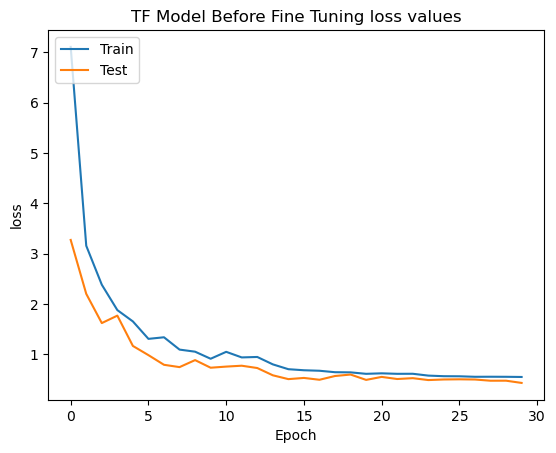

In [15]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('TF Model before Fine Tuning accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

_# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('TF Model Before Fine Tuning loss values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Fine-Tuning the Model:
In this section, the entire model (including the VGG16 base model) is unfrozen, and the model is compiled again with a lower learning rate. This process is called fine-tuning.


In [16]:
base_model.trainable = True
model.summary()
adam = optimizers.Adam(1e-5)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 14,717,766
Non-trainable params: 0
_________________________________________________________________


# Importantly
Here although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

## Training the Model After Fine-Tuning:
The model is trained again after fine-tuning, using the updated parameters. The training process includes early stopping and learning rate reduction.

In [17]:
checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)
callbacks = [checkpoint]
start = datetime.now()

model_history=model.fit(
                      train_set,
                      validation_data=test_set,
                      epochs=20,
                      callbacks= [early_stopping, lr_scheduler, callbacks],
                      verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/20
220/220 [==============================] - ETA: 0s - loss: 0.5061 - accuracy: 0.8266
Epoch 1: val_loss improved from inf to 0.34103, saving model to mymodel.h5
220/220 [==============================] - 108s 448ms/step - loss: 0.5061 - accuracy: 0.8266 - val_loss: 0.3410 - val_accuracy: 0.8830 - lr: 1.0000e-05
Epoch 2/20
220/220 [==============================] - ETA: 0s - loss: 0.3787 - accuracy: 0.8660
Epoch 2: val_loss improved from 0.34103 to 0.33166, saving model to mymodel.h5
220/220 [==============================] - 96s 435ms/step - loss: 0.3787 - accuracy: 0.8660 - val_loss: 0.3317 - val_accuracy: 0.8917 - lr: 1.0000e-05
Epoch 3/20
220/220 [==============================] - ETA: 0s - loss: 0.3514 - accuracy: 0.8784
Epoch 3: val_loss did not improve from 0.33166
220/220 [==============================] - 97s 441ms/step - loss: 0.3514 - accuracy: 0.8784 - val_loss: 0.3408 - val_accuracy: 0.8860 - lr: 1.0000e-05
Epoch 4/20
220/220 [==============================] - ETA

## Plotting Accuracy and Loss After Fine-Tuning:
The accuracy and loss curves are plotted after fine-tuning to visualize the improvements.

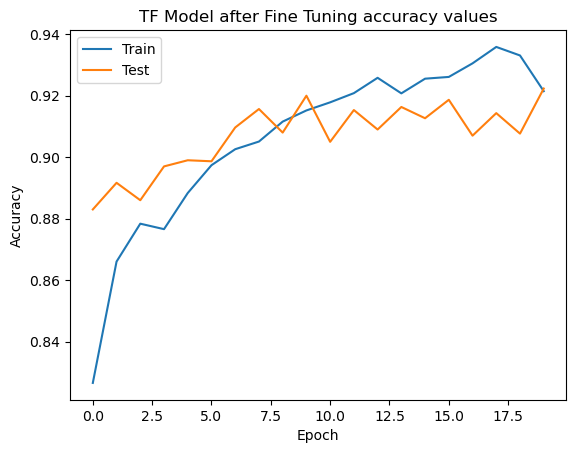

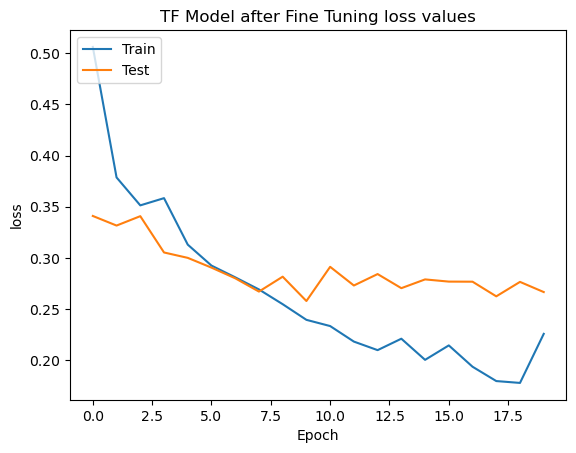

In [18]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('TF Model after Fine Tuning accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

_# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('TF Model after Fine Tuning loss values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Model Prediction and Visualization:
The trained model is used to predict the classes of the test images, and the first 20 test images with their predicted labels are visualized.

94/94 [==============================] - 6s 45ms/step



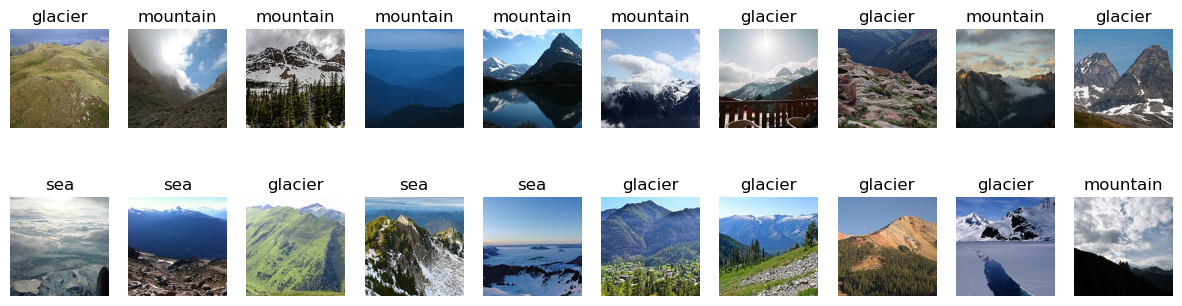

In [19]:
prediction = model.predict(test_images)
figure, axes = plt.subplots(2, 10, figsize=(15,4))
axes = axes.ravel()
print()
for index in range(0,20):
    axes[index].imshow((test_images[index])/255,cmap=plt.cm.binary)
    axes[index].set_title(class_names[np.argmax(prediction[index])])
    axes[index].axis("off")

# Importent Note
IF you find any difficulty feel free to ask me 
After 10 epochs,  fine-tuning gains us a nice improvement here.
Overall, this code demonstrates how to perform transfer learning using the VGG16 model for image classification and how to fine-tune the model to improve its performance on a specific dataset. The model achieves better accuracy after fine-tuning.

